In [1]:
with open("../../enwiki-20240401-1.txt", "r") as file:
    content = file.read()
print(content)

[[Anarchism]]

CATEGORIES: Anarchism, Anti-capitalism, Anti-fascism, Economic ideologies, Far-left politics, Left-wing politics, Libertarian socialism, Libertarianism, Political culture, Political ideologies, Political movements, Social theories, Socialism

Anarchism is a political philosophy and movement that is against all forms of authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typically including the state and capitalism. Anarchism advocates for the replacement of the state with stateless societies and voluntary free associations. As a historically left-wing movement, this reading of anarchism is placed on the farthest left of the political spectrum, usually described as the libertarian wing of the socialist movement (libertarian socialism).

Although traces of anarchist ideas are found all throughout history, modern anarchism emerged from the Enlightenment. During the latter half of the 19th and the first decades of the 20th c

In [2]:
import re
# Funciones de limpieza
def remove_newlines_and_whitespace(text):
     # Elimina nuevas líneas y reemplaza con espacio
    text = re.sub(r'[\r\n]+', ' ', text)
    # Convierte múltiples espacios a un solo espacio y elimina espacios en los extremos
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_unwanted_characters(text):
    # Elimina caracteres de puntuación y especiales
    text = re.sub(r'[^\w\s]', '', text)
    return text

def normalize_text(text):
     # Convierte el texto a minúsculas
    text = text.lower()
    return text

In [3]:
import pandas as pd
# Aplicar funciones de limpieza en secuencia
cleaned_content = normalize_text(remove_unwanted_characters(remove_newlines_and_whitespace(content)))
#df = pd.DataFrame({'text': [remove_newlines(content)]})
# Crear el DataFrame de pandas
df = pd.DataFrame({'text': [cleaned_content]})
df.to_csv('processed.csv', index=False)
df.head()

,text
0,anarchism categories anarchism anticapitalism ...


<Axes: >

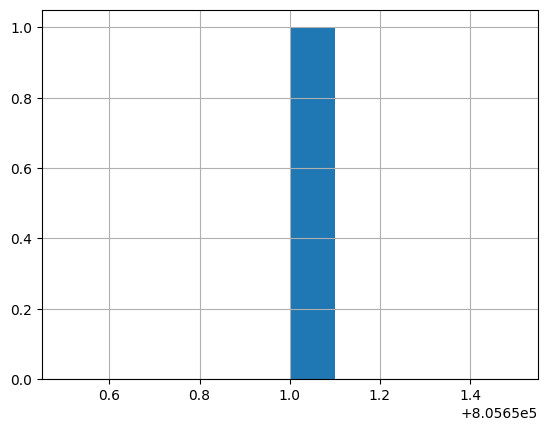

In [24]:
import tiktoken
import matplotlib
tokenizer = tiktoken.get_encoding("cl100k_base")
df = pd.read_csv('processed.csv')
df.columns = ['text']
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [25]:
max_tokens = 150
# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):
    # Split the text into sentences
    sentences = text.split('.\n')
    
    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    chunks = []
    tokens_so_far = 0
    chunk = []
    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):
        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0
        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue
        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1
    return chunks
# shortened = []

# shortened = split_into_many(content)
shortened = []
# print(shortened)
# print(len(shortened))
for row in df.iterrows():
    if row[1]['text'] is None:
        continue
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(content)
    else:
        shortened.append(content)

<Axes: >

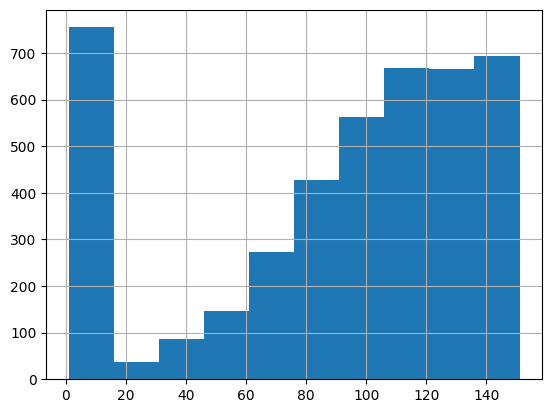

In [26]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [27]:
from openai import OpenAI

client = OpenAI(
    api_key="",
)

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding


df['embeddings'] = df.text.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
df.to_csv('embedings.csv', index=False)
df.head()

,text,n_tokens,embeddings
0,"[[Anarchism]]\n\nCATEGORIES: Anarchism, Anti-c...",149,"[-0.025945305824279785, -0.008460425771772861,..."
1,"\nAnarchists employ diverse approaches, which ...",79,"[-0.019291071221232414, -0.0002869920863304287..."
2,\nThe first political philosopher to call hims...,111,"[0.01036249939352274, -0.020561115816235542, 0..."
3,\nWhile opposition to the state is central to ...,105,"[-0.009823445230722427, 0.018128542229533195, ..."
4,\n==History==\n\n===Pre-modern era===\n\nThe m...,83,"[0.03365769237279892, -0.01405937410891056, 0...."


In [28]:
import numpy as np
from scipy.spatial.distance import cosine

df=pd.read_csv('embedings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)
df.head()



,n_tokens,embeddings
text,,
"[[Anarchism]]\n\nCATEGORIES: Anarchism, Anti-capitalism, Anti-fascism, Economic ideologies, Far-left politics, Left-wing politics, Libertarian socialism, Libertarianism, Political culture, Political ideologies, Political movements, Social theories, Socialism\n\nAnarchism is a political philosophy and movement that is against all forms of authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typically including the state and capitalism. Anarchism advocates for the replacement of the state with stateless societies and voluntary free associations. As a historically left-wing movement, this reading of anarchism is placed on the farthest left of the political spectrum, usually described as the libertarian wing of the socialist movement (libertarian socialism).",149,"[-0.025945305824279785, -0.008460425771772861,..."
"\nAnarchists employ diverse approaches, which may be generally divided into revolutionary and evolutionary strategies; there is significant overlap between the two. Evolutionary methods try to simulate what an anarchist society might be like, but revolutionary tactics, which have historically taken a violent turn, aim to overthrow authority and the state. Many facets of human civilization have been influenced by anarchist theory, critique, and praxis.",79,"[-0.019291071221232414, -0.0002869920863304287..."
"\nThe first political philosopher to call himself an anarchist (anarchiste) was Pierre-Joseph Proudhon (1809–1865), marking the formal birth of anarchism in the mid-19th century. Since the 1890s and beginning in France, libertarianism has often been used as a synonym for anarchism and its use as a synonym is still common outside the United States. Some usages of libertarianism refer to individualistic free-market philosophy only, and free-market anarchism in particular is termed libertarian anarchism.",111,"[0.01036249939352274, -0.020561115816235542, 0..."
"\nWhile opposition to the state is central to anarchist thought, defining anarchism is not an easy task for scholars, as there is a lot of discussion among scholars and anarchists on the matter, and various currents perceive anarchism slightly differently. Major definitional elements include the will for a non-coercive society, the rejection of the state apparatus, the belief that human nature allows humans to exist in or progress toward such a non-coercive society, and a suggestion on how to act to pursue the ideal of anarchy.",105,"[-0.009823445230722427, 0.018128542229533195, ..."
"\n==History==\n\n===Pre-modern era===\n\nThe most notable precursors to anarchism in the ancient world were in China and Greece. In China, philosophical anarchism (the discussion on the legitimacy of the state) was delineated by Taoist philosophers Zhuang Zhou and Laozi. Alongside Stoicism, Taoism has been said to have had ""significant anticipations"" of anarchism.",83,"[0.03365769237279892, -0.01405937410891056, 0...."


In [29]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    q_embeddings = get_embedding(question)
    # q_embeddings = client.embeddings.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']
    # Get the distances from the embeddings
    df["distances"] = df["embeddings"].apply(lambda x: cosine(q_embeddings, x))

    returns = []
    cur_len = 0
    
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        cur_len += row['n_tokens'] + 4
        if cur_len > max_len:
            break
        returns.append(str(i))
    return ", ".join(returns)


In [30]:
def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=500,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Contexto:\n")
        print(context)
        print("\n\n")

    try:
        # Create a chat completion using the question and context
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Responde la pregunta basandote en el contexto, hazlo de manera clara. Si no puedes reponder basado en el contexto, solamente di 'Escribe AGENTE para más información.'"},
                {"role": "system", "content": f"contexto: {context}"},
                {"role": "user", "content": f"pregunta: {question}"},
                {"role": "assistant", "content": "respuesta:"}
                # {"role": "user", f"content": "Contexto: {context}\n\n---\n\nPregunta: {question}\nRespuesta:"}
            ],
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(e)
        return ""

In [32]:
answer_question(df, question="What are the main themes?", max_tokens=100)

'Los principales temas son la aventura al enfrentar la naturaleza, temas económicos, arte y derecho, y teoría estética.'

In [35]:
answer_question(df, question="What does it say about nature?")

'En el contexto proporcionado, se menciona que Schopenhauer consideraba que la monarquía es "natural para el hombre de casi la misma manera que lo es para las abejas y las hormigas, para las grullas en vuelo, para los elefantes errantes, para los lobos en manada en busca de presas, y para otros animales". También se menciona que Schopenhauer despreciaba el republicanismo por considerarlo "tan antinatural para el hombre como desfavorable para la vida intelectual superior y, por lo tanto, para las artes y las ciencias".'

In [36]:
answer_question(df, question="What does it say about the economy?", max_tokens=100)

'El contexto proporciona información sobre la economía de varios países, como Albania y España, incluyendo detalles sobre sectores como el bancario, turismo, agricultura, manufactura y comercio. También menciona medidas fiscales implementadas y datos económicos como el valor del producto interno bruto (PIB) y la tasa de desempleo.'

In [38]:
answer_question(df, question="Are you talking about economics?", max_tokens=100)

'Sí, el contexto habla sobre diferentes aspectos económicos a lo largo de la historia, como las actitudes hacia los trabajadores, la industria, los impuestos, la crisis de deuda soberana en Europa, entre otros temas relacionados con la economía.'

In [48]:
answer_question(df, question="What is the atomic number", max_tokens=100)

'El número atómico es el número de carga nuclear de un elemento químico, que es igual al número de protones en el núcleo de cada átomo de ese elemento. Se puede utilizar para identificar de manera única los elementos químicos ordinarios.'